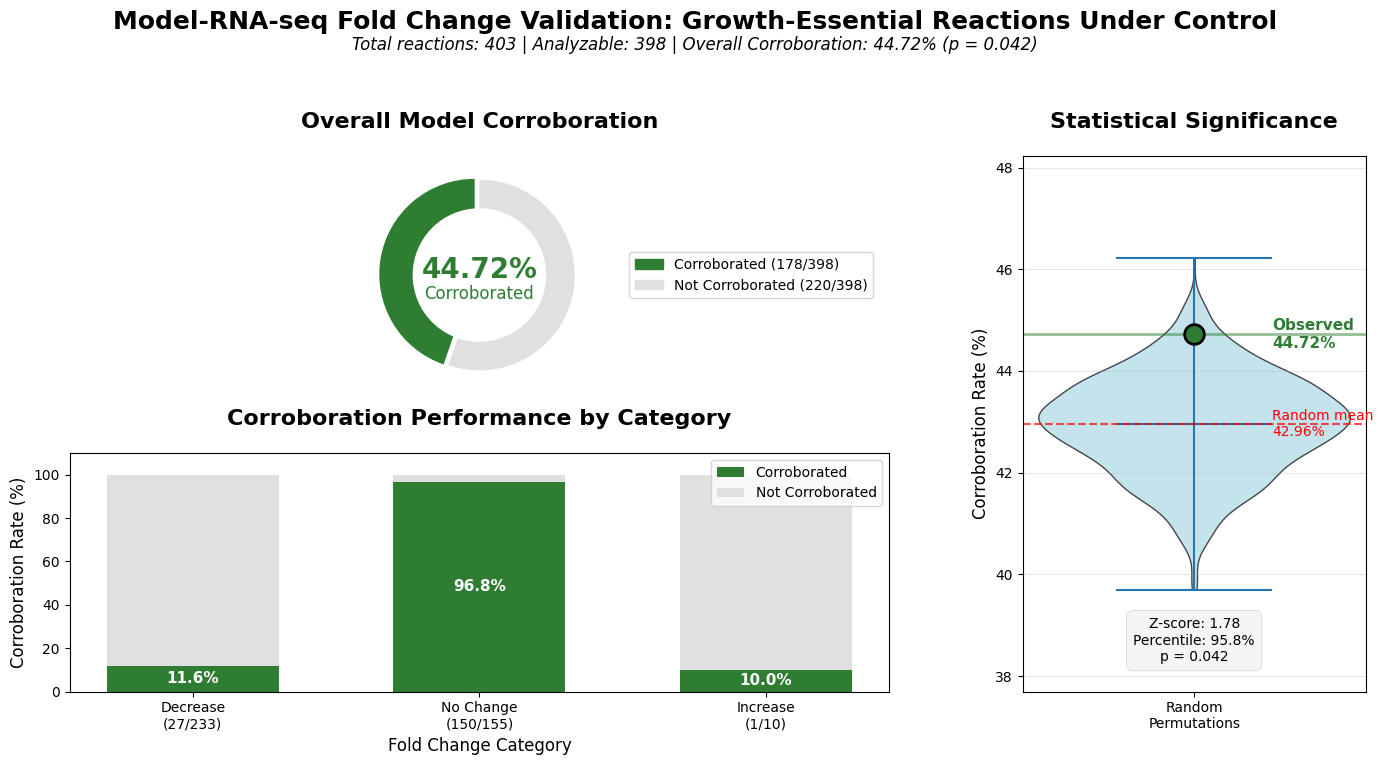

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
from scipy import stats
import pandas as pd  # For loading Excel files

# Set up the figure with a custom layout
fig = plt.figure(figsize=(14, 8))

# Define color scheme
validated_color = '#2E7D32'  # Dark green
not_validated_color = '#E0E0E0'  # Light gray
cat_colors = {'decrease': '#D32F2F', 'no_change': '#1976D2', 'increase': '#F57C00'}
highlight_color = '#FFD54F'  # Yellow for highlighting

# Your data
total_reactions = 403
analyzable_reactions = 398
validated_reactions = 178
validation_pct = 44.72
p_value = 0.042

# Category data
categories = {
    -1: {'validated': 27, 'total': 233, 'pct': 11.6, 'label': 'Decrease'},
    0: {'validated': 150, 'total': 155, 'pct': 96.8, 'label': 'No Change'},
    1: {'validated': 1, 'total': 10, 'pct': 10.0, 'label': 'Increase'}
}

# Random validation stats
random_mean = 42.96
random_std = 0.99

# === Panel A: Validation Overview (Donut Chart) ===
ax1 = plt.subplot(2, 3, (1, 2))

# Donut chart data
sizes = [validation_pct, 100 - validation_pct]
colors = [validated_color, not_validated_color]
explode = (0.05, 0)  # Slightly separate the validated slice

# Create donut
wedges, texts, autotexts = ax1.pie(sizes, colors=colors, labels=['', ''],
                                     autopct='', startangle=90,
                                     explode=explode)

# Make it a donut by adding a white circle in the center
centre_circle = Circle((0, 0), 0.70, fc='white')
ax1.add_artist(centre_circle)

# Add center text with reduced font sizes
ax1.text(0, 0.05, f'{validation_pct}%', ha='center', va='center',
         fontsize=20, weight='bold', color=validated_color)
ax1.text(0, -0.2, 'Corroborated', ha='center', va='center',
         fontsize=12, color=validated_color)

# Add title
ax1.set_title('Overall Model Corroboration', fontsize=16, weight='bold', pad=20)

# Add legend
legend_elements = [
    mpatches.Patch(color=validated_color, label=f'Corroborated ({validated_reactions}/{analyzable_reactions})'),
    mpatches.Patch(color=not_validated_color, label=f'Not Corroborated ({analyzable_reactions - validated_reactions}/{analyzable_reactions})')
]
ax1.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.1, 0.5))

# === Panel B: Category-Specific Performance ===
ax2 = plt.subplot(2, 3, (4, 5))

# Prepare data for grouped bar chart
categories_list = [-1, 0, 1]
category_labels = [categories[cat]['label'] for cat in categories_list]
# Create labels with counts on second line
category_labels_with_counts = [f"{categories[cat]['label']}\n({categories[cat]['validated']}/{categories[cat]['total']})"
                               for cat in categories_list]
validation_rates = [categories[cat]['pct'] for cat in categories_list]
not_validated_rates = [100 - rate for rate in validation_rates]

# Set up bar positions
x = np.arange(len(categories_list))
width = 0.6

# Create stacked bars
bars1 = ax2.bar(x, validation_rates, width, label='Corroborated',
                color=validated_color)  # Use same green color for all validated bars
bars2 = ax2.bar(x, not_validated_rates, width, bottom=validation_rates,
                label='Not Corroborated', color=not_validated_color)

# Add value labels on bars
for i, (cat, bar) in enumerate(zip(categories_list, bars1)):
    height = bar.get_height()
    # Add percentage on the validated portion
    ax2.text(bar.get_x() + bar.get_width()/2, height/2, f'{height:.1f}%',
             ha='center', va='center', fontsize=11, weight='bold', color='white')

# Customize the plot
ax2.set_ylabel('Corroboration Rate (%)', fontsize=12)
ax2.set_xlabel('Fold Change Category', fontsize=12)
ax2.set_title('Corroboration Performance by Category', fontsize=16, weight='bold', pad=20)
ax2.set_xticks(x)
ax2.set_xticklabels(category_labels_with_counts)
ax2.set_ylim(0, 110)  # Start at 0
ax2.legend(loc='upper right')

# === Panel C: Statistical Context ===
ax3 = plt.subplot(2, 3, (3, 6))

# Load your permutation data from Excel file
# Since your Excel has no headers, use header=None
# Option 1: If your data is in the first column
# df = pd.read_excel('your_permutation_results.xlsx', header=None)
# random_validations = df[0].values  # First column (index 0)

# Option 2: If your data is in a row
# df = pd.read_excel('your_permutation_results.xlsx', header=None)
# random_validations = df.iloc[0, :].values  # First row

# Option 3: If data is scattered across the sheet, flatten everything
# df = pd.read_excel('your_permutation_results.xlsx', header=None)
# random_validations = df.values.flatten()
# random_validations = random_validations[~np.isnan(random_validations)]  # Remove NaN values

# Load actual permutation data from Excel
df = pd.read_excel('permuted_percentages.xlsx', header=None)
random_validations = df.values.flatten()  # Flatten to 1D array
random_validations = random_validations[~np.isnan(random_validations)]  # Remove any NaN values

# Create violin plot
parts = ax3.violinplot([random_validations], positions=[0], widths=0.6,
                       showmeans=True, showextrema=True)

# Customize violin plot
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')

# Add observed value as a distinct point
ax3.scatter([0], [validation_pct], color=validated_color, s=200, zorder=5,
           edgecolors='black', linewidth=2)

# Add horizontal lines for reference
ax3.axhline(y=validation_pct, color=validated_color, linestyle='-',
           linewidth=2, alpha=0.5)

# Calculate actual statistics from the permutation data
actual_random_mean = np.mean(random_validations)
actual_random_std = np.std(random_validations)
ax3.axhline(y=actual_random_mean, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Calculate z-score and percentile
z_score = (validation_pct - actual_random_mean) / actual_random_std
percentile = (np.sum(random_validations < validation_pct) / len(random_validations)) * 100

# Add text annotations
ax3.text(0.15, validation_pct, f'Observed\n{validation_pct}%',
         ha='left', va='center', fontsize=11, weight='bold', color=validated_color)
ax3.text(0.15, actual_random_mean, f'Random mean\n{actual_random_mean:.2f}%',
         ha='left', va='center', fontsize=10, color='red')

# Add summary statistics in the lower part with a subtle box for formatting
ax3.text(0, min(random_validations) - 1,
         f'Z-score: {z_score:.2f}\nPercentile: {percentile:.1f}%\np = {p_value}',
         ha='center', va='center', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#F5F5F5', edgecolor='lightgray', linewidth=0.5))

# Customize the plot
ax3.set_ylabel('Corroboration Rate (%)', fontsize=12)
ax3.set_xticks([0])
ax3.set_xticklabels(['Random\nPermutations'])
ax3.set_ylim(min(random_validations) - 2, max(max(random_validations), validation_pct) + 2)
ax3.set_title('Statistical Significance', fontsize=16, weight='bold', pad=20)

# Add grid for better readability
ax3.grid(True, axis='y', alpha=0.3)

# Optional: Add histogram bars behind violin for better visualization
# ax3.hist(random_validations, bins=30, alpha=0.3, color='gray', orientation='horizontal',
#          density=True, zorder=1)

# === Overall figure adjustments ===
# Add main title
fig.suptitle('Model-RNA-seq Fold Change Validation: Growth-Essential Reactions Under Control',
             fontsize=18, weight='bold', y=0.98)

# Add subtitle with key stats
fig.text(0.5, 0.93,
         f'Total reactions: {total_reactions} | Analyzable: {analyzable_reactions} | ' +
         f'Overall Corroboration: {validation_pct}% (p = {p_value})',
         ha='center', fontsize=12, style='italic')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.92])


# Optional: Save the figure
plt.savefig('model_validation_dashboard.png', dpi=300, bbox_inches='tight')
plt.savefig('model_validation_dashboard.pdf', bbox_inches='tight')  # For publication
plt.show()
